# Import module, packages

In [3]:
!pip install iPython_SQL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv, sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Business Understanding and Analytic Approach

•	Mục tiêu: Phân tích giá bất động sản tại các khu vực ngoại thành như McLean (gần WashingtonDc), Santa Monica (gần Los Angeles), và Stamford (gần New York.).  
•	Tiếp cận: So sánh giá nhà tại các khu vực ngoại thành với giá nhà tại trung tâm thành phố, phân tích các yếu tố ảnh hưởng đến sự chênh lệch giá.  


# 2. Data Collection, Understanding, Preparation

### Dataset: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [2]:
df_McLean = pd.read_csv('McLean_WashingtonDc.csv')
df_SantaMonica = pd.read_csv('SantaMonica_LosAngeles.csv')
df_Stamford = pd.read_csv('Stamford_NewYork.csv')
df = pd.concat([df_McLean, df_SantaMonica, df_Stamford], ignore_index=True)

### Data Cleaning

In [3]:
df

,city,state,house_size,bed,bath,price
0,McLean,Virginia,1141.0,2.0,2.0,435000.0
1,McLean,Virginia,779.0,1.0,1.0,265000.0
2,McLean,Virginia,6180.0,6.0,6.0,1873990.0
3,McLean,Virginia,17743.0,8.0,10.0,7500000.0
4,McLean,Virginia,12354.0,7.0,10.0,9500000.0
...,...,...,...,...,...,...
1742,Stamford,Connecticut,4626.0,NaN,4.0,1499000.0
1743,Stamford,Connecticut,1314.0,3.0,2.0,619900.0
1744,Stamford,Connecticut,3193.0,4.0,4.0,799000.0
1745,Stamford,Connecticut,3734.0,4.0,3.0,949000.0


In [4]:
# 1.Xử lý null

In [5]:
df.isnull().sum()

city           0
state          0
house_size    53
bed           71
bath          50
price          0
dtype: int64

In [6]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.isnull().sum()

city          0
state         0
house_size    0
bed           0
bath          0
price         0
dtype: int64

In [7]:
# 2. Thêm thông tin cho dataset

In [8]:
bins = [0, 2000000, 5000000, 10000000, 50000000, 100000000, 200000000]
labels = ['0-2M', '2M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-200M']

# Chia dữ liệu 'price' vào các khoảng
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

In [9]:
df.dtypes

city             object
state            object
house_size      float64
bed             float64
bath            float64
price           float64
price_range    category
dtype: object

# 3. Data Analysis with SQL

In [10]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [11]:
#Kích Hoạt SQL Magic
%load_ext sql

In [12]:
# Cho phép SQL Magic kết nối với CSDL
%sql sqlite:///HouseData.db

In [13]:
# Import DataFrame vào cơ sở dữ liệu
df.to_sql('BigCity', con, if_exists='replace', index=False)

1664

In [14]:
%%sql
SELECT *
FROM BigCity
WHERE [house_size] >= 20000;


 * sqlite:///HouseData.db
Done.


city,state,house_size,bed,bath,price,price_range
McLean,Virginia,23600.0,6.0,11.0,29900000.0,10M-50M
McLean,Virginia,20000.0,8.0,13.0,24000000.0,10M-50M
McLean,Virginia,21337.0,6.0,9.0,10500000.0,10M-50M
McLean,Virginia,22000.0,10.0,15.0,22000000.0,10M-50M
McLean,Virginia,20000.0,7.0,11.0,5800000.0,5M-10M
McLean,Virginia,20000.0,7.0,13.0,12000000.0,10M-50M
Santa Monica,California,20513.0,40.0,31.0,10250000.0,10M-50M
Stamford,Connecticut,20264.0,19.0,24.0,9385000.0,5M-10M


In [15]:
con.close()

# 4. Data Analysis with Python

### Phân tích giá nhà tại các khu ngoại thành

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [16]:
stats = df.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
stats

Thống kê mô tả tổng quát cho bất động sản:


,house_size,bed,bath,price
count,1664.000000,1664.000000,1664.000000,1.664000e+03
mean,3103.120793,3.632812,3.693510,1.901406e+06
std,2996.043815,2.504914,2.715149,2.301573e+06
min,427.000000,1.000000,1.000000,1.169000e+05
25%,1232.000000,2.000000,2.000000,6.060000e+05
50%,1920.000000,3.000000,3.000000,1.199000e+06
75%,3823.000000,5.000000,5.000000,2.299250e+06
max,23600.000000,40.000000,31.000000,2.990000e+07


In [17]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df.groupby('city')['price'].var()
price_variance_by_location

city
McLean          5.682508e+12
Santa Monica    6.607983e+12
Stamford        8.472102e+11
Name: price, dtype: float64

In [18]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df['city'].value_counts()
count_by_province

city
McLean          650
Santa Monica    576
Stamford        438
Name: count, dtype: int64

In [19]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = df['price'].std() / df['price'].mean()
cv

1.2104587283286528

Hệ số biến thiên 121%: Cho thấy mức độ phân tán của giá nhà lớn ở các khu vực ngoại thành tại Mỹ

In [20]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df['price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 1408939.033543333


In [21]:
# 12. Độ phân tán của giá (range)
price_range = df['price'].max() - df['price'].min()
price_range

29783100.0

In [22]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
outliers
#outliers.sort_values(by='price', inplace=True, ascending=True)

,city,state,house_size,bed,bath,price,price_range
3,McLean,Virginia,17743.0,8.0,10.0,7500000.0,5M-10M
4,McLean,Virginia,12354.0,7.0,10.0,9500000.0,5M-10M
8,McLean,Virginia,10178.0,6.0,9.0,8500000.0,5M-10M
17,McLean,Virginia,12210.0,8.0,11.0,4950000.0,2M-5M
28,McLean,Virginia,5595.0,6.0,5.0,7995000.0,5M-10M
...,...,...,...,...,...,...,...
1233,Stamford,Connecticut,20264.0,19.0,24.0,9385000.0,5M-10M
1375,Stamford,Connecticut,18166.0,6.0,8.0,6495000.0,5M-10M
1452,Stamford,Connecticut,14149.0,13.0,12.0,7995000.0,5M-10M
1591,Stamford,Connecticut,7712.0,7.0,10.0,4950000.0,2M-5M


In [23]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df['price_range'].value_counts()
price_frequency

price_range
0-2M         1173
2M-5M         378
5M-10M         92
10M-50M        21
50M-100M        0
100M-200M       0
Name: count, dtype: int64

In [24]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df['price'].corr(df['house_size'])
corr_price_area

0.671286007244813

Hệ số tương quan ~ 0.67 --> Có một mối quan hệ tương quan nhất định

In [25]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df['price'].corr(df['bed'])
corr_price_bedroom

0.5105139589487551

In [26]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df.groupby('city')['price'].mean()
mean_price_by_location.sort_values(ascending=False)

city
Santa Monica    2.732548e+06
McLean          1.922288e+06
Stamford        7.774070e+05
Name: price, dtype: float64

In [27]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df['price'].std() / df['price'].mean()
price_dispersion

1.2104587283286528

In [28]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df[df['price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df[df['price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:           city        state  house_size   bed  bath       price price_range
3       McLean     Virginia     17743.0   8.0  10.0   7500000.0      5M-10M
4       McLean     Virginia     12354.0   7.0  10.0   9500000.0      5M-10M
8       McLean     Virginia     10178.0   6.0   9.0   8500000.0      5M-10M
17      McLean     Virginia     12210.0   8.0  11.0   4950000.0       2M-5M
28      McLean     Virginia      5595.0   6.0   5.0   7995000.0      5M-10M
...        ...          ...         ...   ...   ...         ...         ...
1233  Stamford  Connecticut     20264.0  19.0  24.0   9385000.0      5M-10M
1375  Stamford  Connecticut     18166.0   6.0   8.0   6495000.0      5M-10M
1452  Stamford  Connecticut     14149.0  13.0  12.0   7995000.0      5M-10M
1591  Stamford  Connecticut      7712.0   7.0  10.0   4950000.0       2M-5M
1628  Stamford  Connecticut      6442.0  10.0  10.0  10000000.0      5M-10M

[127 rows x 7 columns]
Outliers lower: Empty DataFrame
Columns: [city, 

In [29]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df['price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25      606000.0
0.50     1199000.0
0.75     2299250.0
1.00    29900000.0
Name: price, dtype: float64

# 5. Data Visualization

In [30]:
df.head(5)

,city,state,house_size,bed,bath,price,price_range
0,McLean,Virginia,1141.0,2.0,2.0,435000.0,0-2M
1,McLean,Virginia,779.0,1.0,1.0,265000.0,0-2M
2,McLean,Virginia,6180.0,6.0,6.0,1873990.0,0-2M
3,McLean,Virginia,17743.0,8.0,10.0,7500000.0,5M-10M
4,McLean,Virginia,12354.0,7.0,10.0,9500000.0,5M-10M


In [61]:
#1.	Bar Plot: So sánh giá trung bình giữa các khu ngoại thành tại Mỹ.

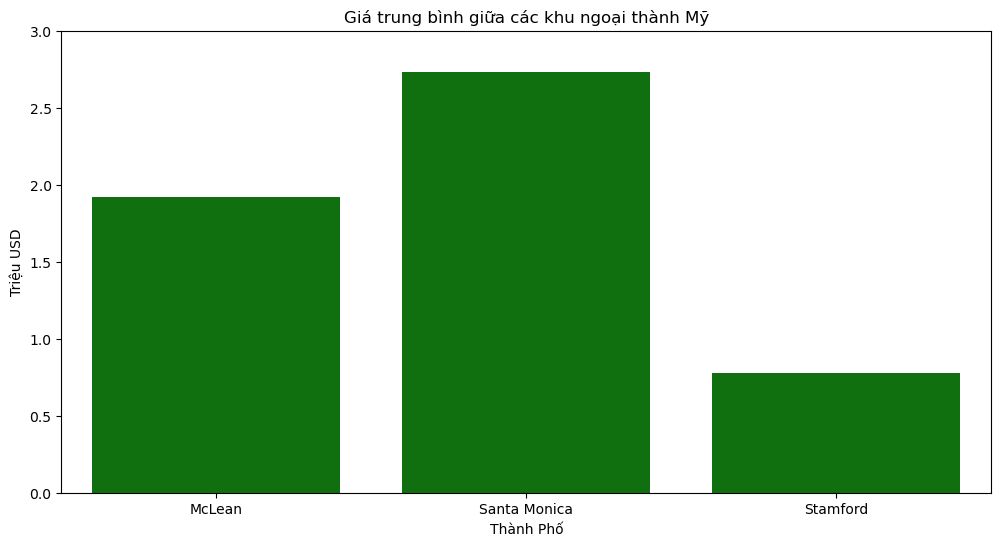

In [59]:
average_province = df.groupby('city')['price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các khu ngoại thành Mỹ')
plt.xlabel('Thành Phố')
plt.ylabel('Triệu USD');

In [33]:
# 2. Box Plot: Hiển thị phân phối giá ở các vùng khác nhau.

9


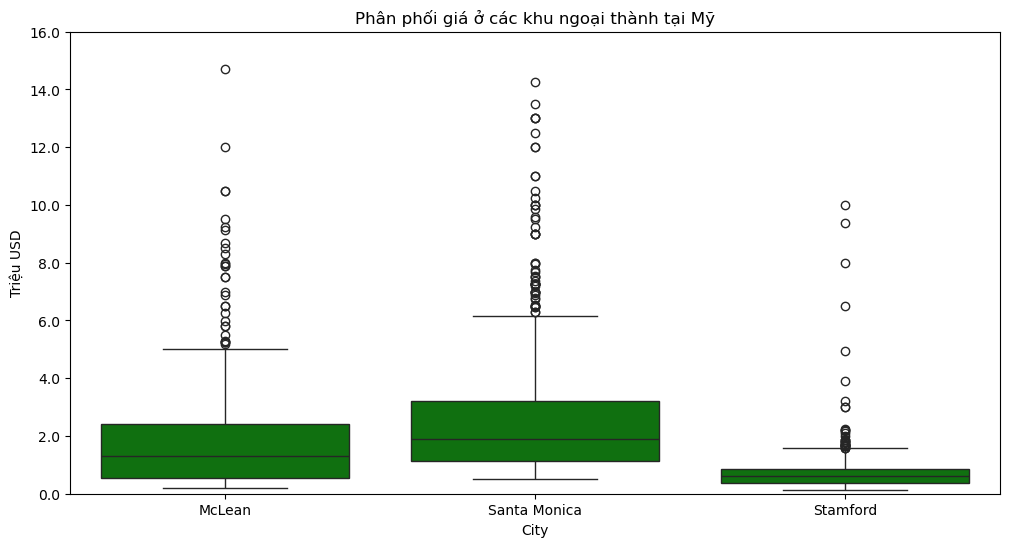

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df, color='Green')

plt.ylim(0, 15000000)
yticks = plt.yticks()[0]
print(len(yticks))
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Phân phối giá ở các khu ngoại thành tại Mỹ')
plt.xlabel('City')
plt.ylabel('Triệu USD');

In [35]:
#3. Violin Plot: Phân tích sự phân tán giá.

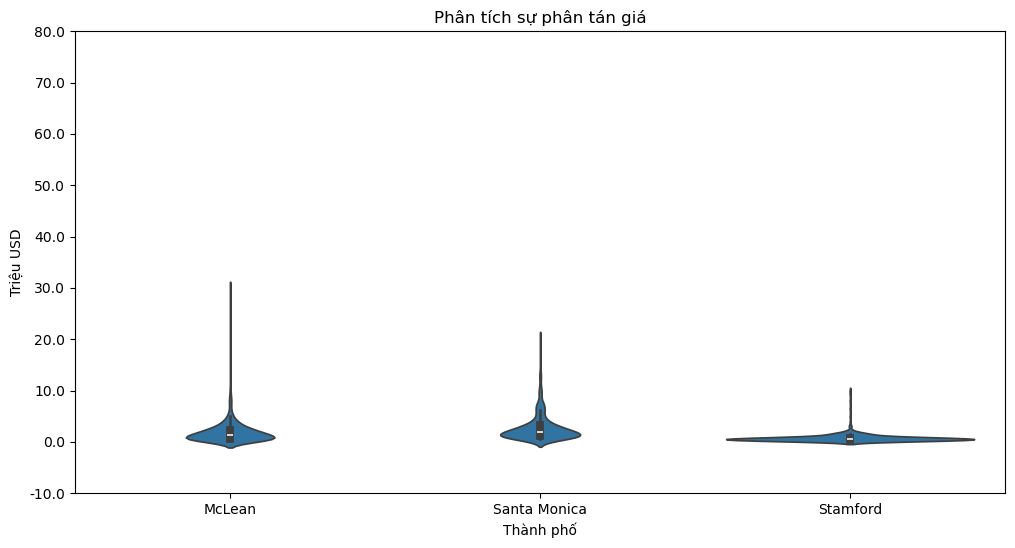

In [36]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='city', y='price', data=df)

plt.ylim(-1000000, 75000000)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Thành phố')
plt.ylabel('Triệu USD');


In [37]:
# 4.Scatter Plot: Quan hệ giữa giá và số phòng ngủ.

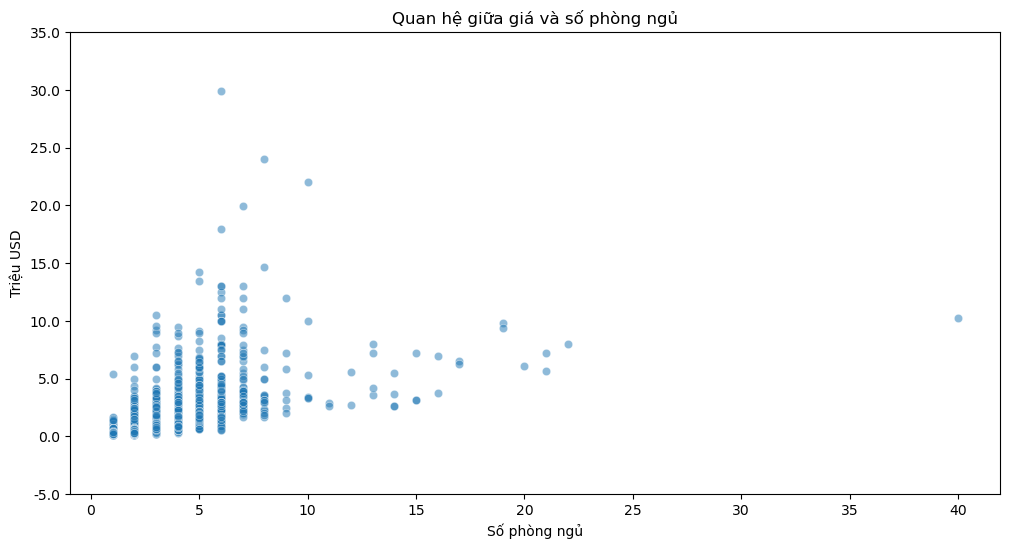

In [38]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bed', y='price', data=df, alpha=0.5)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Triệu USD');

In [39]:
# 6.Pie Chart: Phân bố số lượng bất động sản theo khu vực.

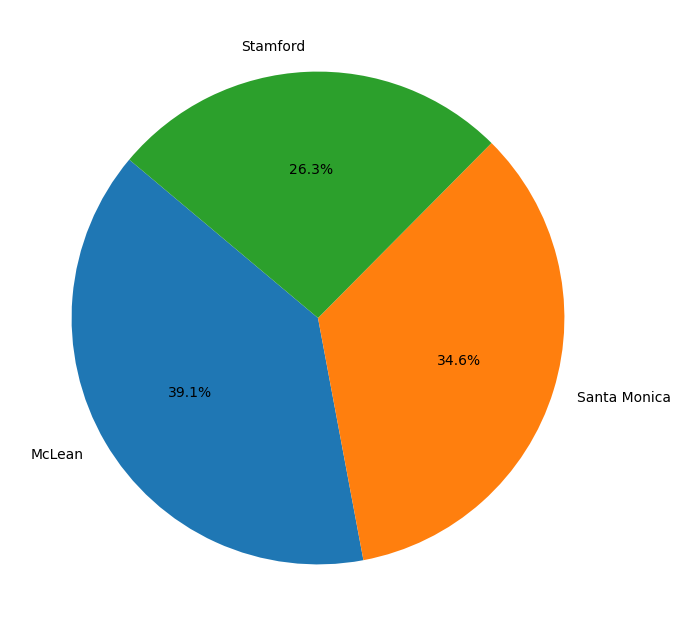

In [40]:
real_estate_counts = df['city'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

In [41]:
# Histogram: Phân phối giá của bất động sản.

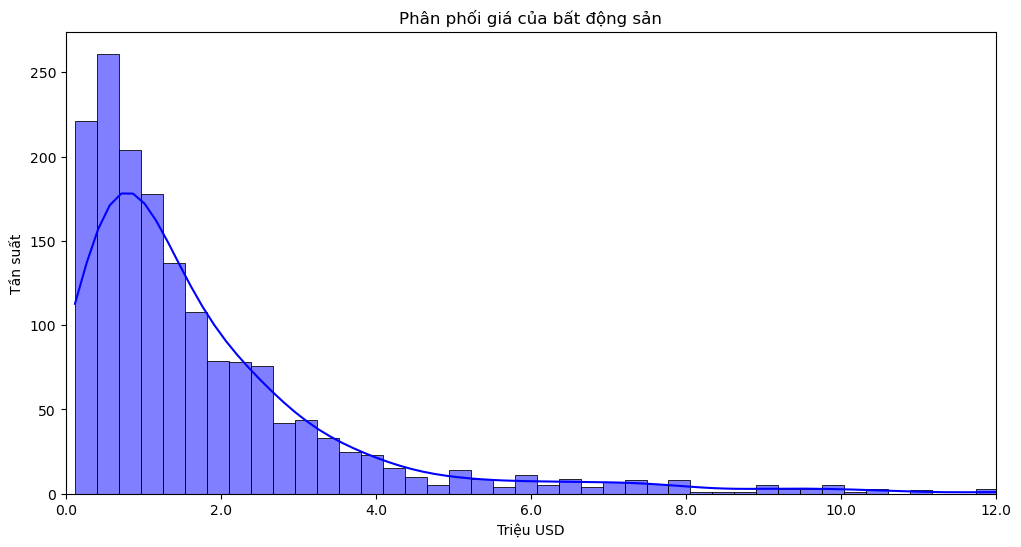

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue')

plt.xlim(0, 12000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

In [43]:
# Histogram: Phân phối tích lũy giá nhà

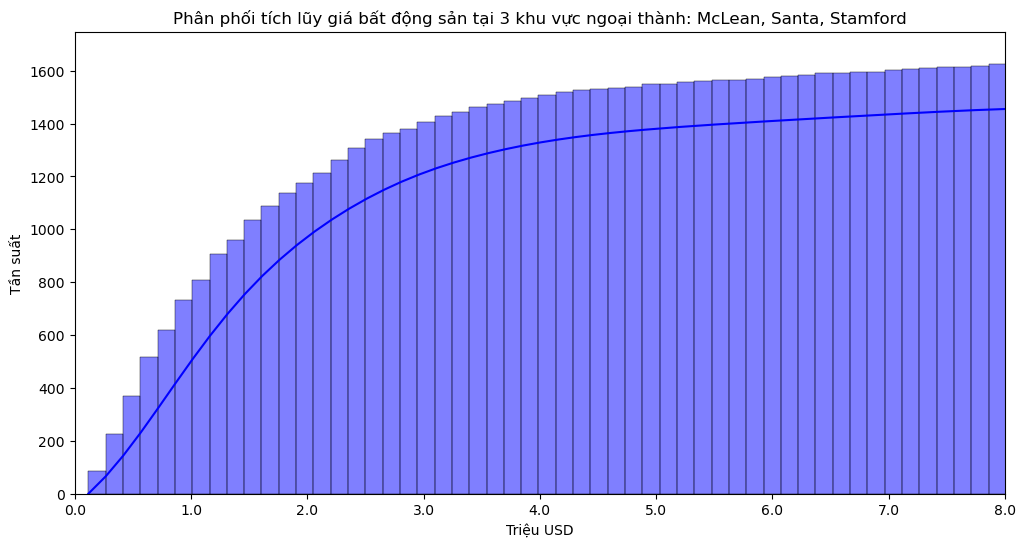

In [63]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue', cumulative=True, bins=200)

plt.xlim(0, 8000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối tích lũy giá bất động sản tại 3 khu vực ngoại thành: McLean, Santa, Stamford')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

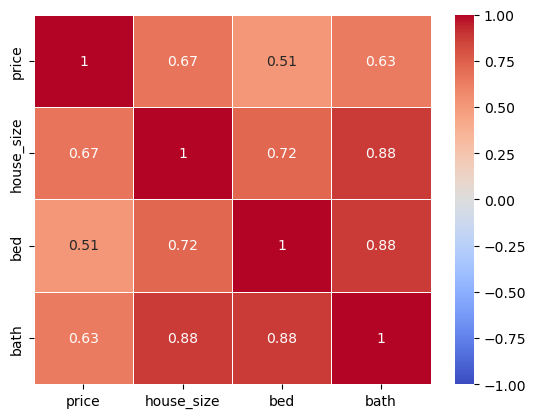

In [45]:
# Heatmap: Tương quan giữa giá và các yếu tố khác.
corr_matrix = df[['price', 'house_size', 'bed', 'bath']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [46]:
# Pair Plot: Tương quan giữa các biến số khác nhau.

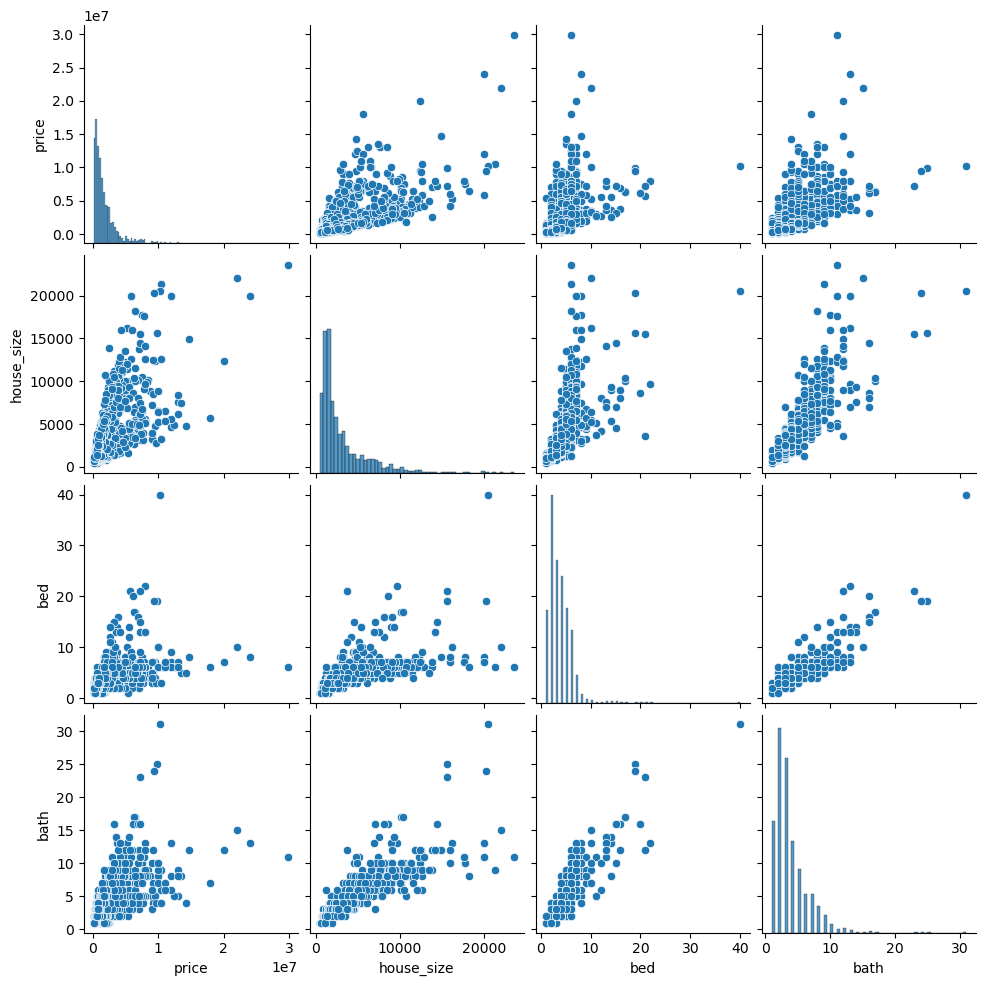

In [47]:
sns.pairplot(df[['price', 'house_size', 'bed', 'bath']]);

In [48]:
# Density Plot

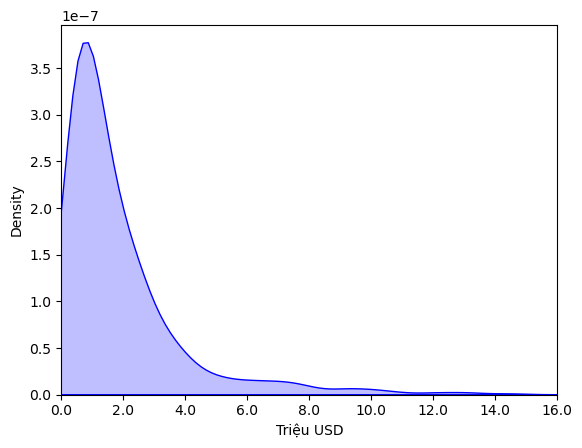

In [49]:
sns.kdeplot(df['price'], color='blue', fill=True)

plt.xlim(0, 15000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in xticks])

plt.xlabel('Triệu USD');

In [50]:
# Area Plot: Hiển thị xu hướng giá.

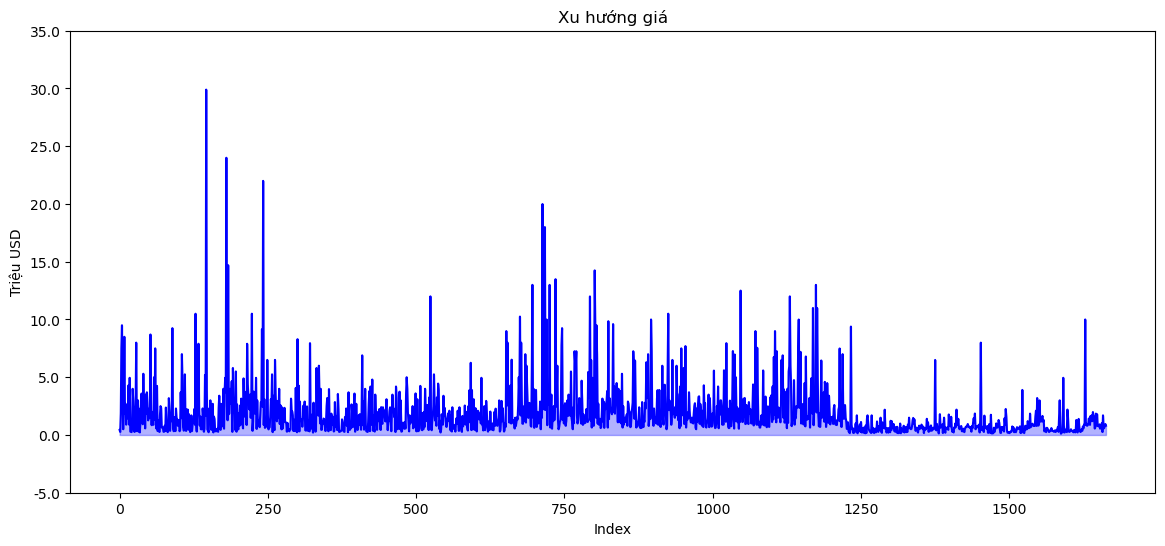

In [51]:
plt.figure(figsize=(14,6))

sns.lineplot(data=df['price'], color='blue')
plt.fill_between(df.index, df['price'], color='blue', alpha=0.3)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Xu hướng giá')
plt.xlabel('Index')
plt.ylabel('Triệu USD');

In [52]:
# Biểu đồ bong bóng của giá bất động sản theo diện tích

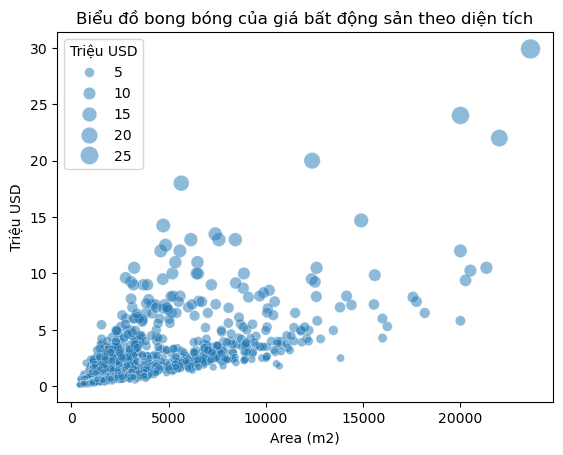

In [67]:
price_million = df['price'].apply(lambda x: x/(10**6))

sns.scatterplot(x=df.house_size, y=price_million, size=price_million, sizes=(20, 200), alpha=0.5)

plt.title('Biểu đồ bong bóng của giá bất động sản theo diện tích')
plt.xlabel('Area (m2)')
plt.ylabel('Triệu USD')

plt.legend(title='Triệu USD', fontsize='10');

# 6. Regression Analysis

In [54]:
# Huấn luyện mô hình
df['city_encoded'] = LabelEncoder().fit_transform(df['city'])
X = df[['house_size', 'bed', 'bath', 'city_encoded']]
Y = df[['price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
price_predictions = model.predict(X_test)

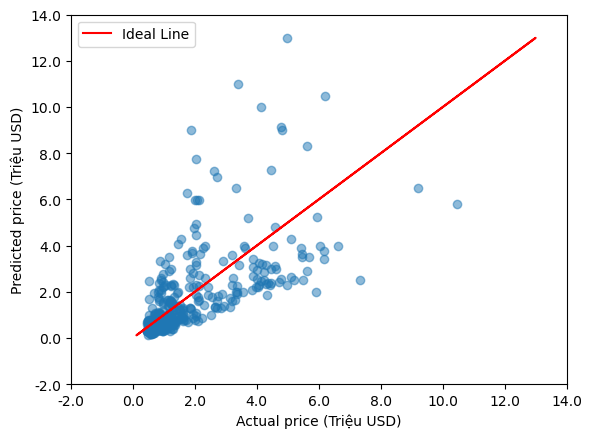

In [55]:
# Visualize khả năng dự đoán
plt.scatter(x=price_predictions, y=Y_test.values, alpha=0.5)
plt.plot(Y_test.values, Y_test.values, color='red', label='Ideal Line')

plt.ylabel('Predicted price (Triệu USD)')
plt.xlabel('Actual price (Triệu USD)')
plt.legend()

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks]);

In [56]:
# Đánh giá hiệu suất model

In [57]:
mse = mean_squared_error(Y_test, price_predictions)
mae = mean_absolute_error(Y_test, price_predictions)
r2 = r2_score(Y_test, price_predictions)
intercept = model.intercept_  
coefficients = model.coef_   

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² score: {r2}")
print(f"Intercept (β0 - Hằng số): {intercept}")
print(f"Hệ số hồi quy (β1, β2, β3,...): {coefficients}")

Mean Squared Error (MSE): 2534796162840.419
Mean Absolute Error (MAE): 1045879.9158618543
R² score: 0.32015637109173
Intercept (β0 - Hằng số): [52789.76002657]
Hệ số hồi quy (β1, β2, β3,...): [[    427.02841982 -114363.35839365  241206.33490143   66019.47071755]]


# 7. Data Analysis with Tool

In [69]:
#df.to_csv('outskirts_dataset.csv')